In [10]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
import matplotlib.pyplot as plt
%matplotlib inline

from chainer import iterators
from chainer import optimizers
import numpy as np
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

### Prepare dataset

label: 5


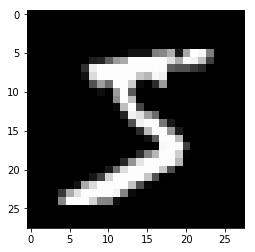

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
from chainer.datasets import mnist

# Download the MNIST data if you haven't downloaded it yet
train, test = mnist.get_mnist(withlabel=True, ndim=1)

# Display an example from the MNIST dataset.
# `x` contains the inpu t image array and `t` contains that target class
# label as an integer.
x, t = train[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.savefig('5.png')
print('label:', t)

### Create a dataset iterator

In [3]:
# Choose the minibatch size.
batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

### Create the network as a subclass of Chain

In [4]:
class MLP(Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)

    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        return self.l3(h)

model = MLP()

### Choose an optimization algorithm

In [5]:
# Choose an optimizer algorithm
optimizer = optimizers.MomentumSGD(lr=0.01, momentum=0.9)

# Give the optimizer a reference to the model so that it
# can locate the model's parameters.
optimizer.setup(model)

In [13]:
max_epoch = 10

while train_iter.epoch < max_epoch:

    # One iteration of the training loop 
    train_batch = train_iter.next()
    image_train, target_train = concat_examples(train_batch, -1)

    # Calculate the prediction of the network
    prediction_train = model(image_train)

    # Calculate the loss with softmax_cross_entropy
    loss = F.softmax_cross_entropy(prediction_train, target_train)

    # Calculate the gradients in the network
    model.cleargrads()
    loss.backward()

    # Update all the trainable paremters
    optimizer.update()
    # --------------------- until here ---------------------

     # Check the validation accuracy of prediction after every epoch
    if train_iter.is_new_epoch:  # If this iteration is the final iteration of the current epoch

        # Display the training loss
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))), end='')

        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            image_test, target_test = concat_examples(test_batch, -1)

            # Forward the test data
            prediction_test = model(image_test)

            # Calculate the loss
            loss_test = F.softmax_cross_entropy(prediction_test, target_test)
            test_losses.append(to_cpu(loss_test.data))

            # Calculate the accuracy
            accuracy = F.accuracy(prediction_test, target_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)

            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(test_losses), np.mean(test_accuracies)))

epoch:01 train_loss:0.3821 val_loss:0.2596 val_accuracy:0.9245
epoch:02 train_loss:0.2198 val_loss:0.1879 val_accuracy:0.9454
epoch:03 train_loss:0.1999 val_loss:0.1514 val_accuracy:0.9565
epoch:04 train_loss:0.1386 val_loss:0.1339 val_accuracy:0.9610
epoch:05 train_loss:0.1889 val_loss:0.1170 val_accuracy:0.9653
epoch:06 train_loss:0.0735 val_loss:0.1106 val_accuracy:0.9666
epoch:07 train_loss:0.1456 val_loss:0.0975 val_accuracy:0.9689
epoch:08 train_loss:0.0468 val_loss:0.0934 val_accuracy:0.9722
epoch:09 train_loss:0.0713 val_loss:0.0900 val_accuracy:0.9718
epoch:10 train_loss:0.0603 val_loss:0.0914 val_accuracy:0.9722


In [14]:
serializers.save_npz('my_mnist.model', model)